# **U-Net con encoder (MobileNetV2)**

**Autora: Karla Yacolca**

**Primer bloque del sistema de Clasificación por Atipia Nuclear**

Esta primera segmentación se hizo a partir de 43 imágenes de las 162 de BreCaHAD de 1360x1024 , se aplicó normalización y data augmentation para tener un total de 258 imágenes totales de 1024x1024 las que se dividieron en:
Training data:  208
Validation data:  25
Testing data:  25
Con batch=1 y 50 epochs


Referencia: https://github.com/nikhilroxtomar/Unet-with-Pretrained-Encoder 

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/My Drive/PUCP :)/9no ciclo MI/TESIS 1y2_Karla/Avances Tesis 2/Segmentación - Códigos/Unet Keras/Unet_with_encoder/Unet_Pretrain_encoder_final1

/content/drive/My Drive/PUCP :)/9no ciclo MI/TESIS 1y2_Karla/Avances Tesis 2/Segmentación - Códigos/Unet Keras/Unet_with_encoder/Unet_Pretrain_encoder_final1


In [104]:
%ls

BreCaHAD/             Normalizacion.py
Data/                 U-Net_with_Pretrained_MobileNetV2_as_Encoder.ipynb
data_augmentation.py


# Normalización del color

ESTE FUNCIONA, PROBAR QUITANDO LO DE PIP INSTALL, lei q pueede que PIL malogre las imagenes TIFF

In [ ]:
#!pip show pillow

In [ ]:
#!pip install Pillow==4.0.0
#!pip install PIL
#!pip install image
#import PIL.image    #estaba descomentado
import os, sys
from PIL import Image

#Creacion de la nueva carpeta con las imagenes normalizadas: images_norm
os.mkdir('/content/drive/My Drive/PUCP :)/9no ciclo MI/TESIS 1y2_Karla/Avances Tesis 2/Segmentación - Códigos/Unet Keras/Unet_with_encoder/Unet_Pretrain_encoder_final1/BreCaHAD/images_norm')
outfile= "/content/drive/My Drive/PUCP :)/9no ciclo MI/TESIS 1y2_Karla/Avances Tesis 2/Segmentación - Códigos/Unet Keras/Unet_with_encoder/Unet_Pretrain_encoder_final1/BreCaHAD/images_norm"

# Directorio de donde se toman las imagenes originales
imagenes= "/content/drive/My Drive/PUCP :)/9no ciclo MI/TESIS 1y2_Karla/Avances Tesis 2/Segmentación - Códigos/Unet Keras/Unet_with_encoder/Unet_Pretrain_encoder_final1/BreCaHAD/images_original"


#Aplicando normalizacion y guardando en carpeta imagen_norm
%run -i Normalizacion.py
a=0
for infile in os.listdir(imagenes):
#for infile in os.listdir("./"): Con esto solo funciona si 1ero me pongo en la carpeta imagenes
    print( "file : " + infile)
    a=a+1
    im = Image.open(os.path.join(imagenes,infile)) #en open va todo el directorio por eso "join"
    #im.show()
    #outfile = infile[:-3] + "tif"
    [Inorm, H, E] = normalizeStaining(im)
    Image.fromarray(Inorm).save(os.path.join(outfile,infile)) #se guarda en ptro directorio con el mismo nombre infile
    #Inorm.save(outfile,"tif")
    #print( "file : " + outfile)
print("Imagenes procesadas : " + a)


# Data Augmentation

Se hacen 5: CenterCrop, RandomRotate90, GridDistortion, HorizontalFlip, VerticalFlip
Se guardó con numeración 1.tif, 2.tif ......
Las nuevas imágenes están el la carpeta Data

In [123]:
%run -i data_augmentation.py    #corregir lo ultimo en normalizacion.py para que cuente lo del directorio de data y no salga
                                 #Augmented Images: 0 - Augmented Masks: 0

  0%|          | 0/43 [00:00<?, ?it/s]

Original Images: 43 - Original Masks: 43


100%|██████████| 43/43 [00:54<00:00,  1.26s/it]

Augmented Images: 0 - Augmented Masks: 0


# **Red**

## Importing Libraries and Functions

In [124]:
import os
import numpy as np
import cv2
from glob import glob
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from tensorflow.keras.layers import Conv2D, Activation, BatchNormalization
from tensorflow.keras.layers import UpSampling2D, Input, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras import backend as K

In [125]:
print("TensorFlow Version: ", tf.__version__)

TensorFlow Version:  2.3.0


Seeding

In [126]:
np.random.seed(42)
tf.random.set_seed(42)

## Hyperparameters

In [127]:
IMAGE_SIZE = 1024 #256
EPOCHS = 50
BATCH = 1
LR = 1e-4

PATH = "Data/"  #Ya estan normalizadas y segmentadas

## Dataset
You can download the dataset from <a href="https://polyp.grand-challenge.org/CVCClinicDB/">here</a> or from directly from the <a href="https://www.dropbox.com/s/p5qe9eotetjnbmq/CVC-ClinicDB.rar?dl=0">Dropbox</a>.

<br/>
Spliting the data into training, validation and testing with 80:10:10 ratio.

In [128]:
def load_data(path, split=0.1):
    images = sorted(glob(os.path.join(path, "images/*")))
    masks = sorted(glob(os.path.join(path, "masks/*")))

    total_size = len(images)
    valid_size = int(split * total_size)
    test_size = int(split * total_size)

    train_x, valid_x = train_test_split(images, test_size=valid_size, random_state=42)
    train_y, valid_y = train_test_split(masks, test_size=valid_size, random_state=42)

    train_x, test_x = train_test_split(train_x, test_size=test_size, random_state=42)
    train_y, test_y = train_test_split(train_y, test_size=test_size, random_state=42)

    return (train_x, train_y), (valid_x, valid_y), (test_x, test_y)

Reading the images and masks

In [129]:
def read_image(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    path = path.decode()
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    x = np.expand_dims(x, axis=-1)
    return x

Building the tf.data pipeline for training, validation and testing dataset.

In [130]:
def tf_parse(x, y):
    def _parse(x, y):
        x = read_image(x)
        y = read_mask(y)
        return x, y

    x, y = tf.numpy_function(_parse, [x, y], [tf.float64, tf.float64])
    x.set_shape([IMAGE_SIZE, IMAGE_SIZE, 3])
    y.set_shape([IMAGE_SIZE, IMAGE_SIZE, 1])
    return x, y

def tf_dataset(x, y, batch=8):
    dataset = tf.data.Dataset.from_tensor_slices((x, y))
    dataset = dataset.map(tf_parse)
    dataset = dataset.batch(batch)
    dataset = dataset.repeat()
    return dataset

In [131]:
(train_x, train_y), (valid_x, valid_y), (test_x, test_y) = load_data(PATH)

print("Training data: ", len(train_x))
print("Validation data: ", len(valid_x))
print("Testing data: ", len(test_x))

Training data:  208
Validation data:  25
Testing data:  25


In [132]:
def read_and_rgb(x):
    x = cv2.imread(x)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    return x

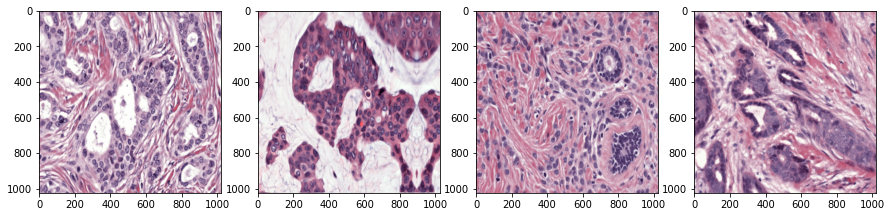

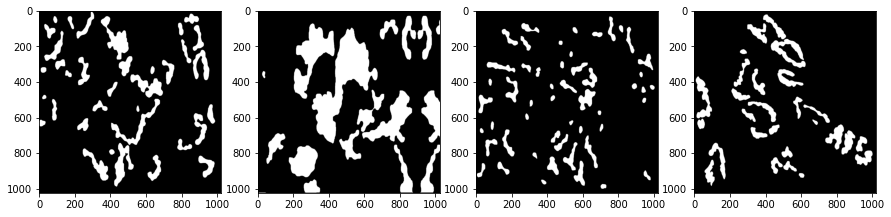

In [133]:
fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_x[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_x[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_x[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_x[3]))
imgplot.set_clim(0.0, 2.1)

fig = plt.figure(figsize=(15, 15))
a = fig.add_subplot(1, 4, 1)
imgplot = plt.imshow(read_and_rgb(train_y[0]))

a = fig.add_subplot(1, 4, 2)
imgplot = plt.imshow(read_and_rgb(train_y[1]))
imgplot.set_clim(0.0, 0.7)

a = fig.add_subplot(1, 4, 3)
imgplot = plt.imshow(read_and_rgb(train_y[2]))
imgplot.set_clim(0.0, 1.4)

a = fig.add_subplot(1, 4, 4)
imgplot = plt.imshow(read_and_rgb(train_y[3]))
imgplot.set_clim(0.0, 1.4)

## Model

In [134]:
def model():
    inputs = Input(shape=(IMAGE_SIZE, IMAGE_SIZE, 3), name="input_image")
    
    encoder = MobileNetV2(input_tensor=inputs, weights="imagenet", include_top=False, alpha=0.35)
    skip_connection_names = ["input_image", "block_1_expand_relu", "block_3_expand_relu", "block_6_expand_relu"]
    encoder_output = encoder.get_layer("block_13_expand_relu").output
    
    f = [16, 32, 48, 64]
    x = encoder_output
    for i in range(1, len(skip_connection_names)+1, 1):
        x_skip = encoder.get_layer(skip_connection_names[-i]).output
        x = UpSampling2D((2, 2))(x)
        x = Concatenate()([x, x_skip])
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
        x = Conv2D(f[-i], (3, 3), padding="same")(x)
        x = BatchNormalization()(x)
        x = Activation("relu")(x)
        
    x = Conv2D(1, (1, 1), padding="same")(x)
    x = Activation("sigmoid")(x)
    
    model = Model(inputs, x)
    return model

In [135]:
model = model()
model.summary()

Model: "functional_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_image (InputLayer)        [(None, 1024, 1024,  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 1025, 1025, 3 0           input_image[0][0]                
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 512, 512, 16) 432         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 512, 512, 16) 64          Conv1[0][0]                      
_______________________________________________________________________________________

## Metrics

In [136]:
smooth = 1e-15
def dice_coef(y_true, y_pred):
    y_true = tf.keras.layers.Flatten()(y_true)
    y_pred = tf.keras.layers.Flatten()(y_pred)
    intersection = tf.reduce_sum(y_true * y_pred)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) + smooth)

def dice_loss(y_true, y_pred):
    return 1.0 - dice_coef(y_true, y_pred)

## Training

In [137]:
train_dataset = tf_dataset(train_x, train_y, batch=BATCH)
valid_dataset = tf_dataset(valid_x, valid_y, batch=BATCH)

In [138]:
opt = tf.keras.optimizers.Nadam(LR)
metrics = [dice_coef, Recall(), Precision()]
model.compile(loss=dice_loss, optimizer=opt, metrics=metrics)

In [139]:
callbacks = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=4),
    EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=False)
]

In [140]:
train_steps = len(train_x)//BATCH
valid_steps = len(valid_x)//BATCH

if len(train_x) % BATCH != 0:
    train_steps += 1
if len(valid_x) % BATCH != 0:
    valid_steps += 1

model.fit(
    train_dataset,
    validation_data=valid_dataset,
    epochs=EPOCHS,
    steps_per_epoch=train_steps,
    validation_steps=valid_steps,
    callbacks=callbacks
)

Epoch 1/50
208/208 [==============================] - 75s 360ms/step - loss: 0.5815 - dice_coef: 0.4185 - recall_3: 0.7933 - precision_3: 0.4587 - val_loss: 0.8549 - val_dice_coef: 0.1451 - val_recall_3: 0.0248 - val_precision_3: 0.9139
Epoch 2/50
208/208 [==============================] - 50s 240ms/step - loss: 0.4915 - dice_coef: 0.5085 - recall_3: 0.8438 - precision_3: 0.5380 - val_loss: 0.9106 - val_dice_coef: 0.0894 - val_recall_3: 7.7544e-06 - val_precision_3: 1.0000
Epoch 3/50
208/208 [==============================] - 50s 240ms/step - loss: 0.4571 - dice_coef: 0.5429 - recall_3: 0.8388 - precision_3: 0.5722 - val_loss: 0.9256 - val_dice_coef: 0.0744 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 4/50
208/208 [==============================] - 50s 240ms/step - loss: 0.4248 - dice_coef: 0.5752 - recall_3: 0.8357 - precision_3: 0.6040 - val_loss: 0.9363 - val_dice_coef: 0.0637 - val_recall_3: 0.0000e+00 - val_precision_3: 0.0000e+00
Epoch 5/50
208/208 [============

# Guardando modelo

In [145]:
model.save('Unet_MovileNetV2.h5')

## Evaluation

In [141]:
test_dataset = tf_dataset(test_x, test_y, batch=BATCH)

test_steps = (len(test_x)//BATCH)
if len(test_x) % BATCH != 0:
    test_steps += 1

model.evaluate(test_dataset, steps=test_steps)

25/25 [==============================] - 9s 342ms/step - loss: 0.3677 - dice_coef: 0.6323 - recall_3: 0.7570 - precision_3: 0.6835


[0.36771777272224426,
 0.6322823166847229,
 0.7569820284843445,
 0.6834580898284912]

## Results

In [142]:
def read_image(path):
    x = cv2.imread(path, cv2.IMREAD_COLOR)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = x/255.0
    return x

def read_mask(path):
    x = cv2.imread(path, cv2.IMREAD_GRAYSCALE)
    x = cv2.resize(x, (IMAGE_SIZE, IMAGE_SIZE))
    x = np.expand_dims(x, axis=-1)
    x = x/255.0
    return x

In [143]:
def mask_parse(mask):
    mask = np.squeeze(mask)
    mask = [mask, mask, mask]
    mask = np.transpose(mask, (1, 2, 0))
    return mask

In [144]:
for i, (x, y) in enumerate(zip(test_x[:25], test_y[:25])):
    x = read_image(x)
    y = read_mask(y)
    y_pred = model.predict(np.expand_dims(x, axis=0))[0] > 0.5
    h, w, _ = x.shape
    white_line = np.ones((h, 10, 3))

    all_images = [
        x, white_line,
        mask_parse(y), white_line,
        mask_parse(y_pred)
    ]
    image = np.concatenate(all_images, axis=1)
    
    fig = plt.figure(figsize=(12, 12))
    a = fig.add_subplot(1, 1, 1)
    imgplot = plt.imshow(image)

Output hidden; open in https://colab.research.google.com to view.

## How to Improve the Results

<ul>
    <li> Use data augmentation </li>
    <li> Use other pretrained encoder </li>
    <li> Use a different decoder or different blocks in the decoder. </li>   
 </ul>

# Thank You

FOLLOW US ON:
<ul>
<li><a href="https://www.youtube.com/idiotdeveloper"> YOUTUBE </a></li>
<li><a href="https://facebook.com/idiotdeveloper"> FACEBOOK </a></li>
<li><a href="https://twitter.com/nikhilroxtomar"> TWITTER </a></li>
<li><a href="https://www.instagram.com/nikhilroxtomar"> INSTAGRAM </a></li>
<li><a href="https://www.patreon.com/idiotdeveloper"> PATREON </a></li>
</ul>